In [1]:
import torch
import numpy as np
import os
from torch.utils.data import Subset
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
import random
from matplotlib import pyplot as plt
from utils import set_seed

from data import MIDIDataset, graph_from_tensor, graph_from_tensor_torch
from model import VAE
from utils import plot_struct, dense_from_sparse, dense_from_sparse_torch, muspy_from_dense, muspy_from_dense_torch
from utils import plot_pianoroll, midi_from_muspy
from train import VAETrainer

Set global seed:

In [2]:
seed = 42
set_seed(seed)

Load model:

In [3]:
models_dir = 'models/'
model = 'LMD2'
gpu = True
device_idx = 3

checkpoint = torch.load(os.path.join(models_dir, model, 'checkpoint'), map_location='cpu')
state_dict = checkpoint['model_state_dict']
params = torch.load(os.path.join(models_dir, model, 'params'), map_location='cpu')

In [4]:
torch.cuda.set_device(device_idx)

device = torch.device("cuda") if gpu else torch.device("cpu")
print("Device:", device)
print("Device idx:", torch.cuda.current_device())

Device: cuda
Device idx: 3


In [5]:
params

{'training': {'batch_size': 256,
  'num_workers': 4,
  'ds_len': 6813946,
  'tr_len': 4769762,
  'vl_len': 681394,
  'ts_len': 1362790},
 'model': {'dropout': 0,
  'batch_norm': True,
  'gnn_n_layers': 8,
  'actsnn_n_layers': 2,
  'd': 512,
  'rnn_n_layers': 1,
  'k_isgn': 3,
  'd_token': 230,
  'd_token_pitches': 131,
  'd_token_dur': 99,
  'n_bars': 2,
  'n_relations': 6,
  'n_tracks': 4,
  'resolution': 8,
  'max_simu_notes': 16},
 'scheduler': {'peak_lr': 0.0001,
  'final_lr_scale': 0.01,
  'warmup_steps': 8000,
  'decay_steps': 800000},
 'optimizer': {'betas': (0.9, 0.98), 'eps': 1e-09, 'lr': 5e-06},
 'beta_annealing': {'beta_update': True,
  'anneal_start': 40000,
  'beta_max': 0.01,
  'step_size': 0.001,
  'anneal_end': 500000}}

In [6]:
vae = VAE(**params['model'], device=device).to(device)
vae.load_state_dict(state_dict)
vae.eval()

VAE(
  (encoder): Encoder(
    (dropout_layer): Dropout(p=0, inplace=False)
    (notes_pitch_emb): Linear(in_features=131, out_features=256, bias=True)
    (drums_pitch_emb): Linear(in_features=131, out_features=256, bias=True)
    (dur_emb): Linear(in_features=99, out_features=256, bias=True)
    (bn_npe): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_dpe): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_de): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (chord_encoder): Linear(in_features=7680, out_features=512, bias=True)
    (graph_encoder): GCN(
      (layers): ModuleList(
        (0): RGCNConv(512, 512, num_relations=6)
        (1): RGCNConv(512, 512, num_relations=6)
        (2): RGCNConv(512, 512, num_relations=6)
        (3): RGCNConv(512, 512, num_relations=6)
        (4): RGCNConv(512, 512, num_relations=6)
        (5): RGCNConv(512, 512, num_relations=6

In [7]:
def generate_music(vae, z, s_cond=None, s_tensor_cond=None):
    
    # Get structure and content logits
    with torch.cuda.amp.autocast():
        _, c_logits, s_tensor_out = vae.decoder(z, s_cond)
    
    s_tensor = s_tensor_cond if s_tensor_cond != None else s_tensor_out
    
    # Build (n_batches x n_bars x n_tracks x n_timesteps x Sigma x d_token)
    # multitrack pianoroll tensor containing logits for each activation and
    # hard silences elsewhere
    mtp = dense_from_sparse_torch(c_logits, s_tensor)
    
    # Collapse bars dimension
    mtp = mtp.permute(0, 2, 1, 3, 4, 5)
    size = (mtp.shape[0], mtp.shape[1], -1, mtp.shape[4], mtp.shape[5])
    mtp = mtp.reshape(*size)
    
    return mtp, s_tensor

In [8]:
import matplotlib as mpl


def save(mtp, dir, s_tensor=None, track_data=None, loop=0):
    
    track_data = ([('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]
                  if track_data == None else track_data)
    
    # Clear matplotlib cache (this avoids formatting problems with first plot)
    plt.clf()

    # Iterate over the generated n-bar sequences
    for i in range(mtp.size(0)):
        
        # Create the directory if it does not exist
        save_dir = os.path.join(dir, str(i))
        os.makedirs(save_dir, exist_ok=True)

        print("Saving midi sequence " + str(i+1) + "...")
        
        # Generate muspy song from multitrack pianoroll, then midi from muspy
        # and save
        muspy_song = muspy_from_dense_torch(mtp[i], track_data, 
                                            params['model']['resolution'])
        midi_from_muspy(muspy_song, save_dir, name='music')
        
        # Plot the pianoroll associated to the sequence
        preset = 'full'
        with mpl.rc_context({'lines.linewidth': 4, 
                             'axes.linewidth': 4, 'font.size': 34}):
            plot_pianoroll(muspy_song, save_dir, name='pianoroll',
                           figsize=(20, 10), fformat='png', preset=preset)
        
        # Plot structure_tensor if present
        if s_tensor != None:
            s_curr = s_tensor[i]
            s_curr = s_curr.permute(1, 0, 2)
            s_curr = s_curr.reshape(s_curr.shape[0], -1)
            with mpl.rc_context({'lines.linewidth': 1, 
                                 'axes.linewidth': 1, 'font.size': 14}):
                plot_struct(s_curr.cpu(), name='structure', 
                            save_dir=save_dir, figsize=(12, 3))

        if loop > 0:
            # Generate extended sequence
            print("Saving extended (looped) midi sequence " + str(i+1) + "...")
            extended = mtp[i].repeat(1, loop+1, 1, 1)
            extended = muspy_from_dense_torch(extended, track_data, 
                                              params['model']['resolution'])
            midi_from_muspy(extended, save_dir, name='extended')
        
        print()

    print("Finished.")

In [9]:
def generate_z(bs, d_model):
    shape = (bs, d_model)

    z_norm = torch.normal(
        torch.zeros(shape, device=device),
        torch.ones(shape, device=device)
    )
    
    return z_norm
    

In [10]:
params

{'training': {'batch_size': 256,
  'num_workers': 4,
  'ds_len': 6813946,
  'tr_len': 4769762,
  'vl_len': 681394,
  'ts_len': 1362790},
 'model': {'dropout': 0,
  'batch_norm': True,
  'gnn_n_layers': 8,
  'actsnn_n_layers': 2,
  'd': 512,
  'rnn_n_layers': 1,
  'k_isgn': 3,
  'd_token': 230,
  'd_token_pitches': 131,
  'd_token_dur': 99,
  'n_bars': 2,
  'n_relations': 6,
  'n_tracks': 4,
  'resolution': 8,
  'max_simu_notes': 16},
 'scheduler': {'peak_lr': 0.0001,
  'final_lr_scale': 0.01,
  'warmup_steps': 8000,
  'decay_steps': 800000},
 'optimizer': {'betas': (0.9, 0.98), 'eps': 1e-09, 'lr': 5e-06},
 'beta_annealing': {'beta_update': True,
  'anneal_start': 40000,
  'beta_max': 0.01,
  'step_size': 0.001,
  'anneal_end': 500000}}

Saving midi sequence 1...

Saving midi sequence 2...

Saving midi sequence 3...

Saving midi sequence 4...

Saving midi sequence 5...

Finished.


<Figure size 432x288 with 0 Axes>

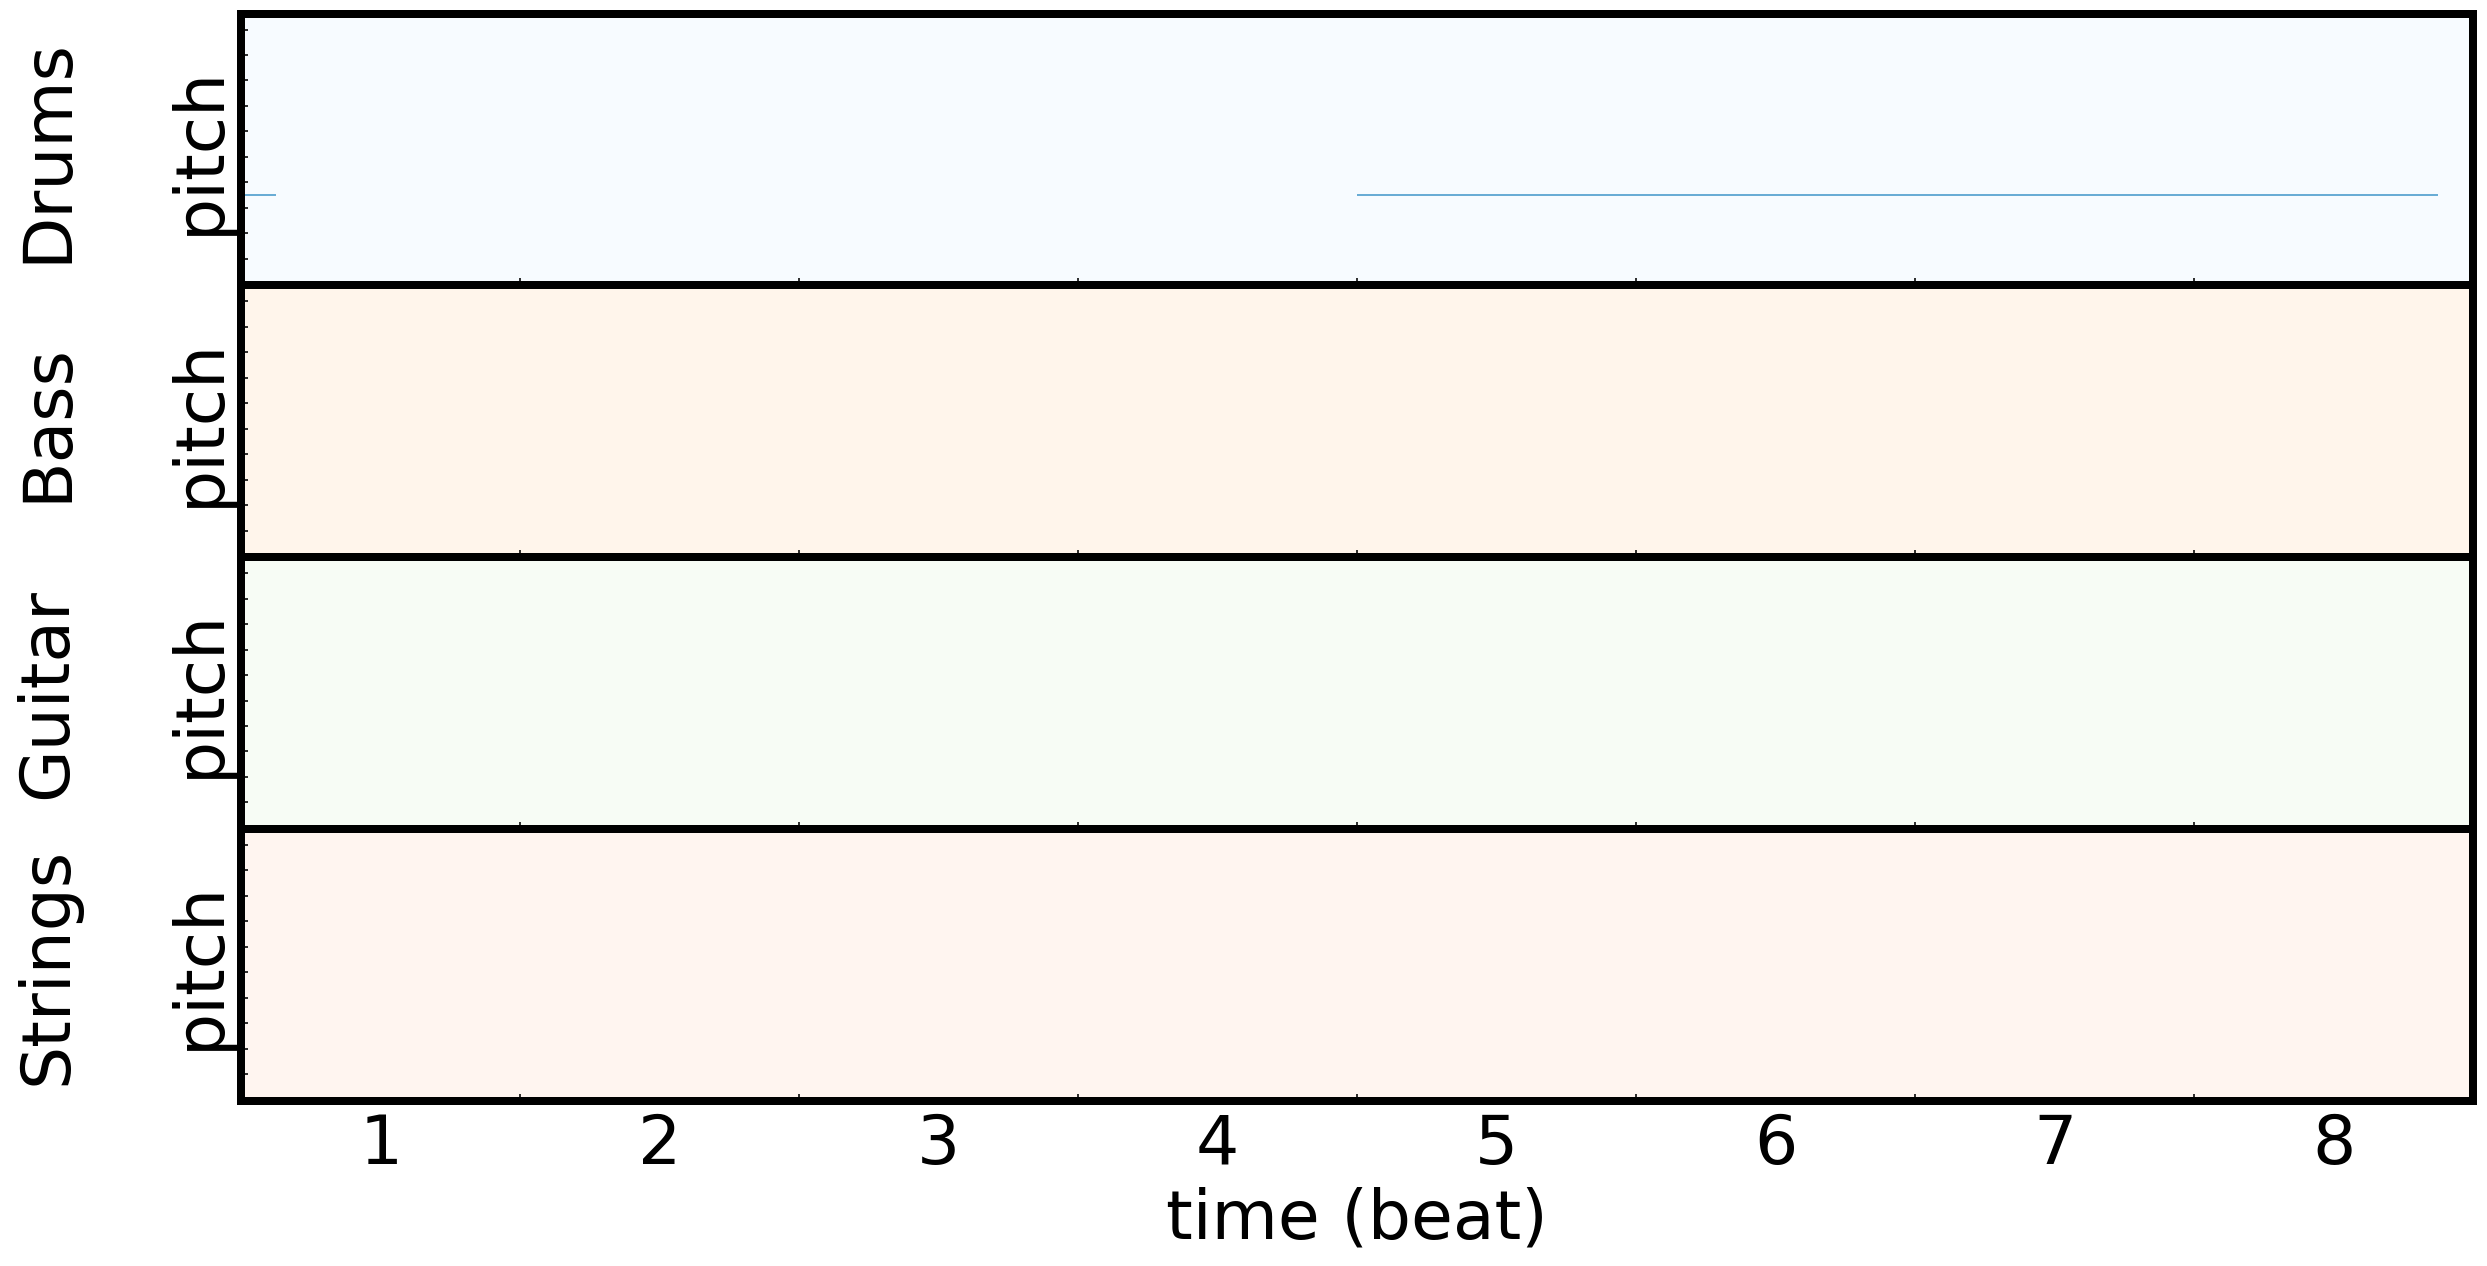

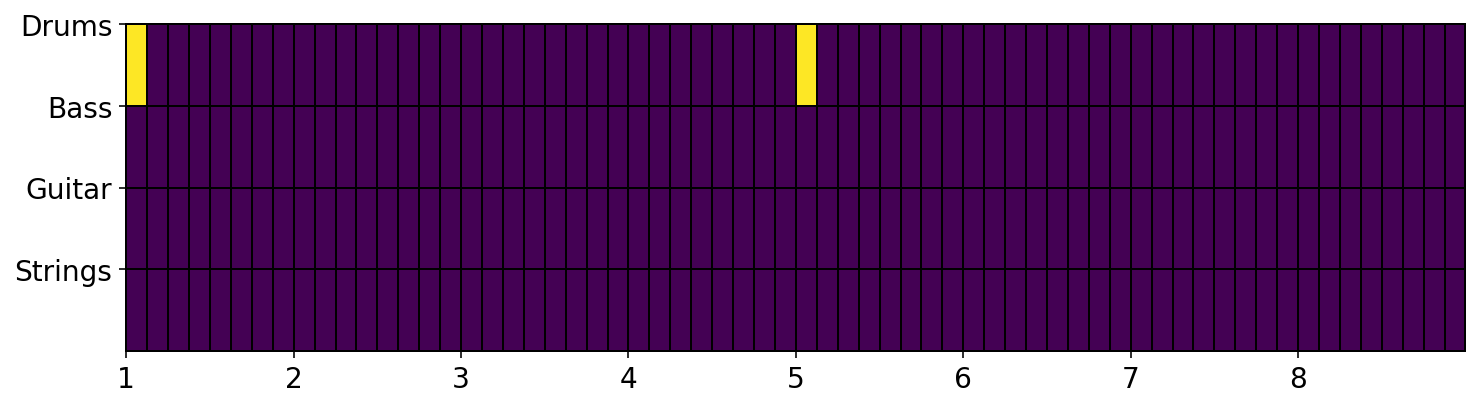

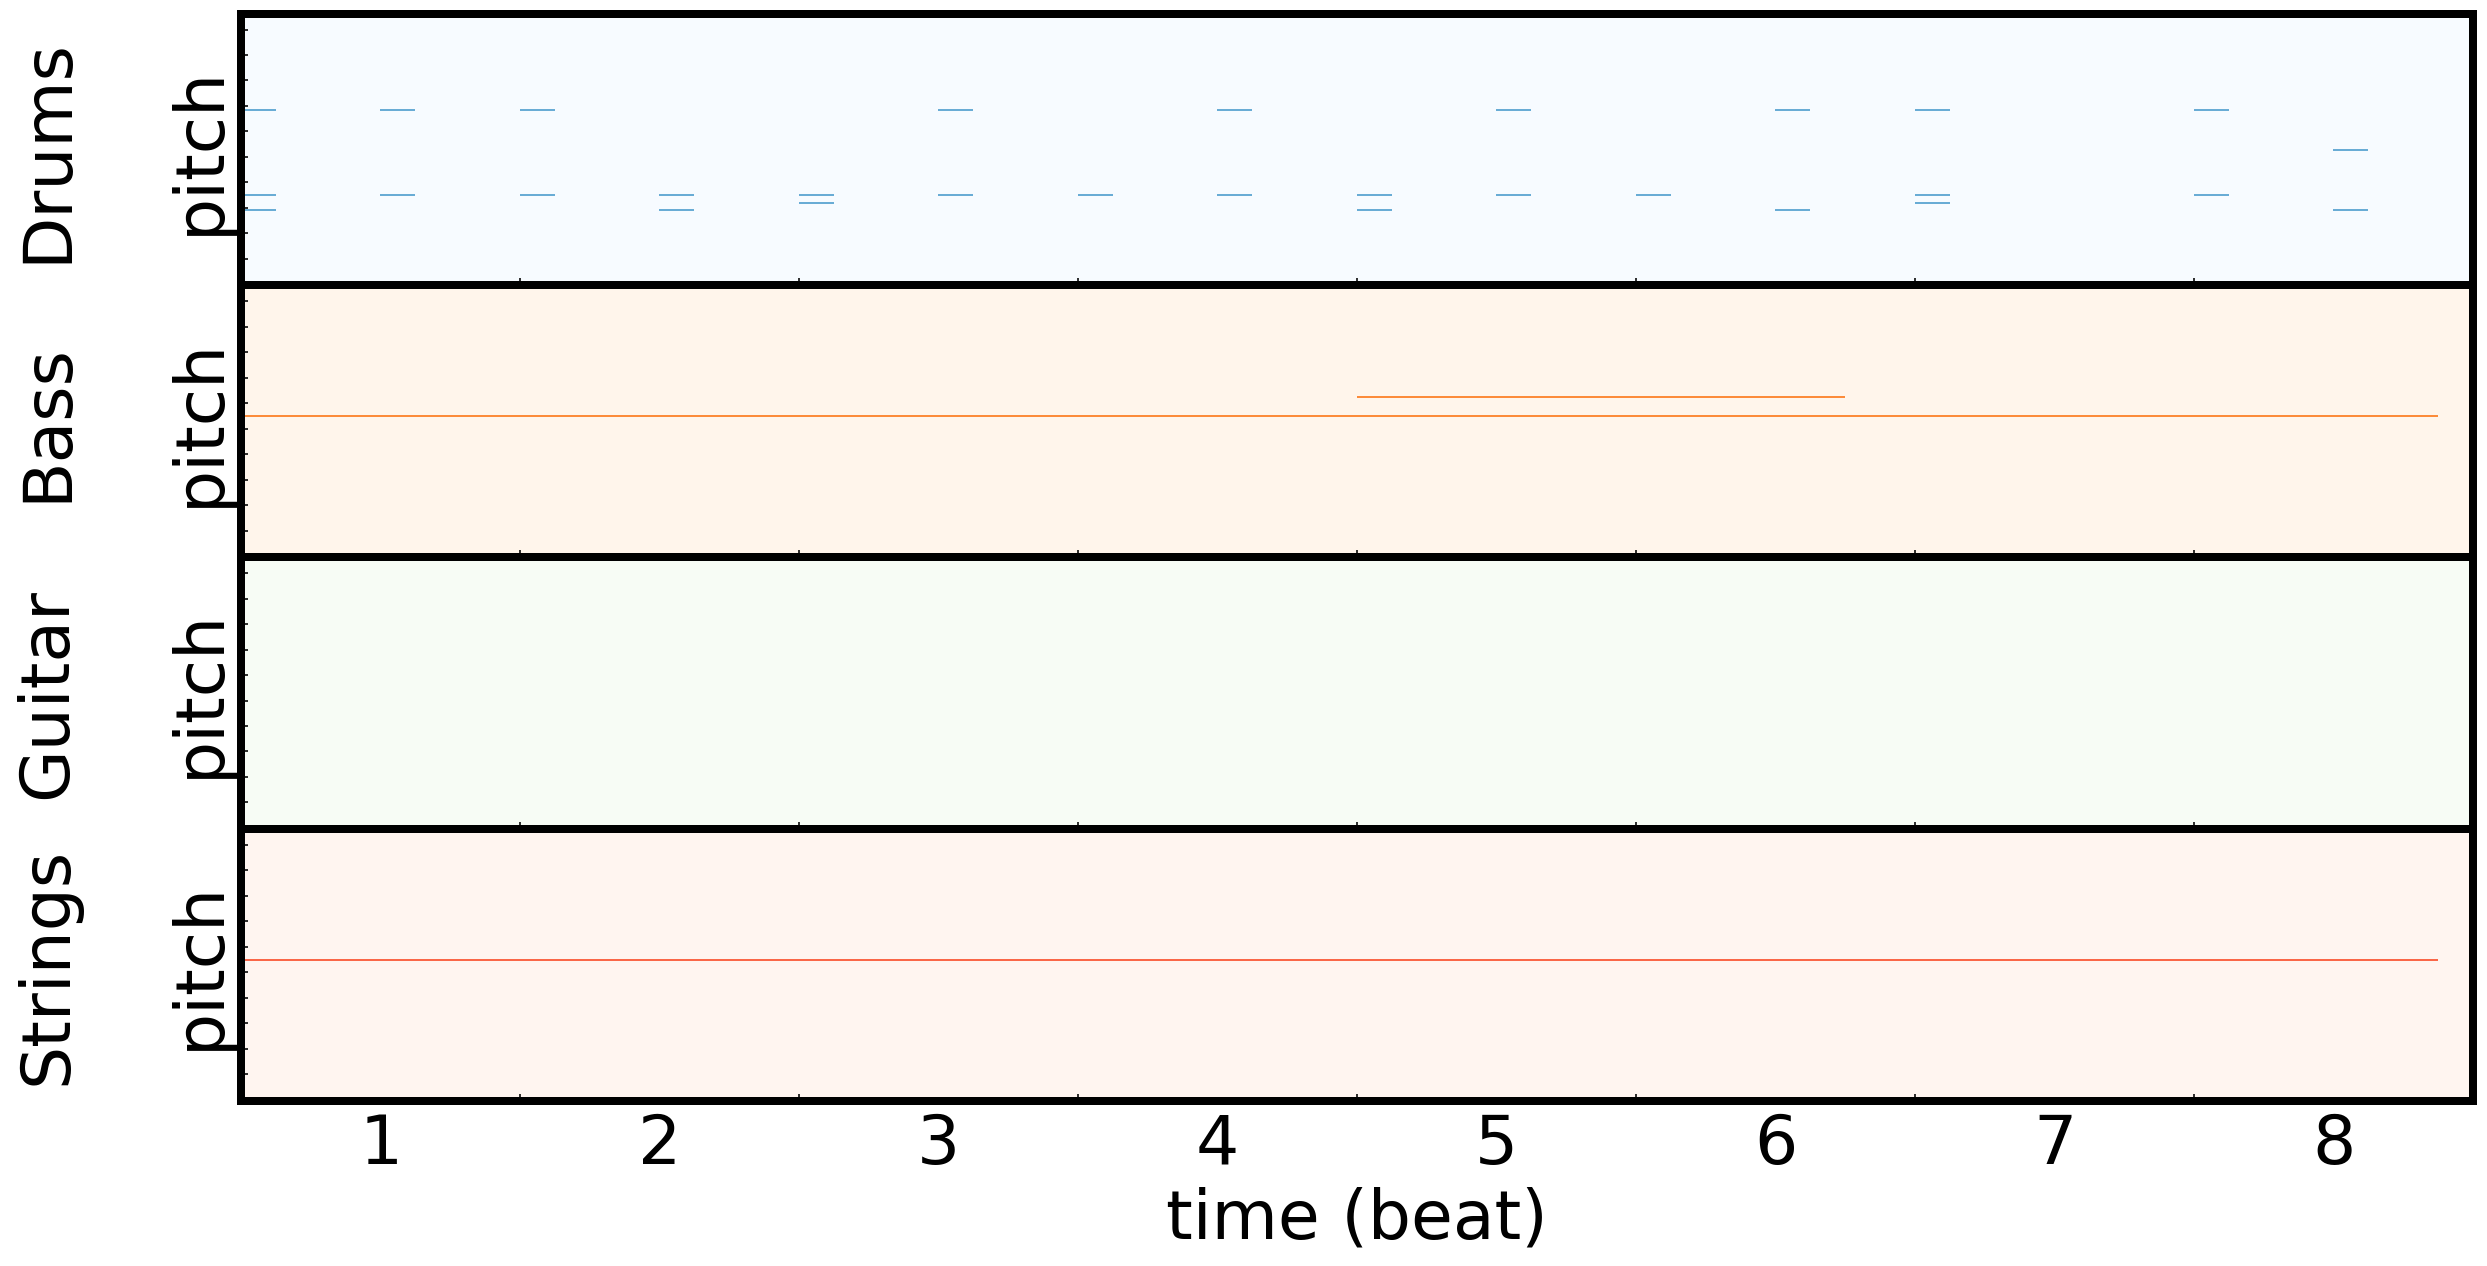

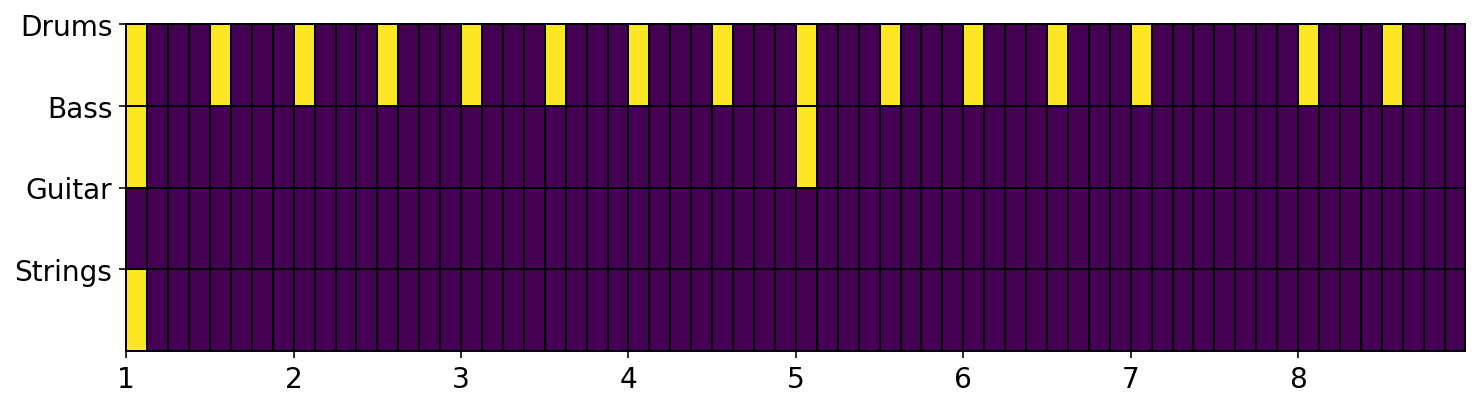

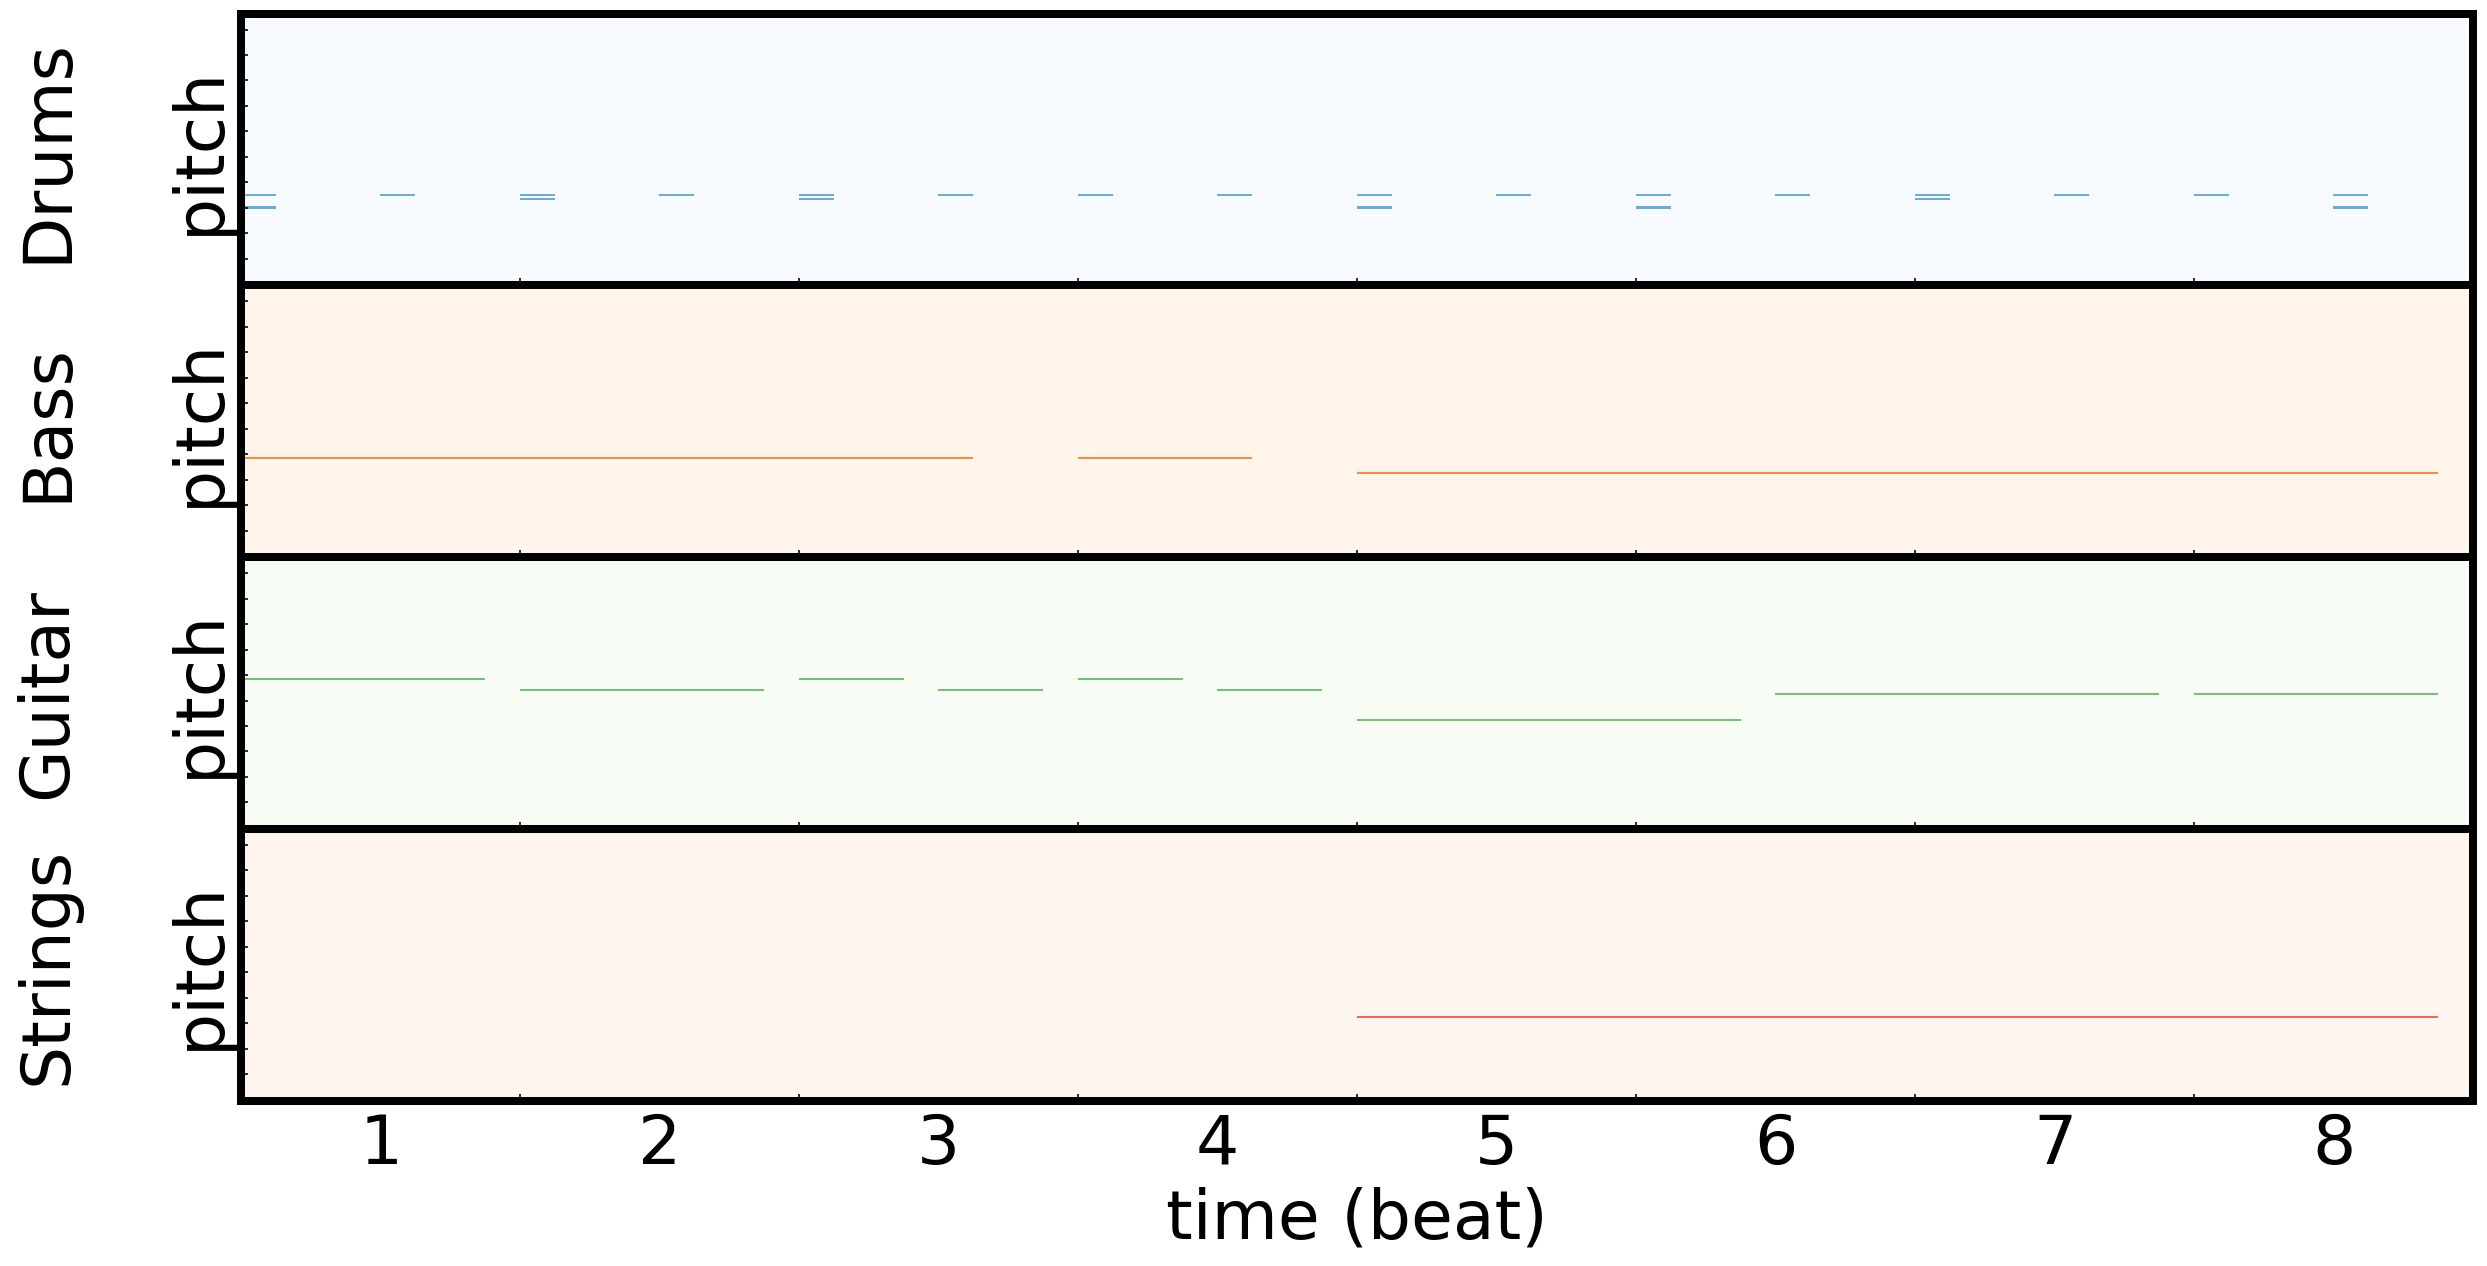

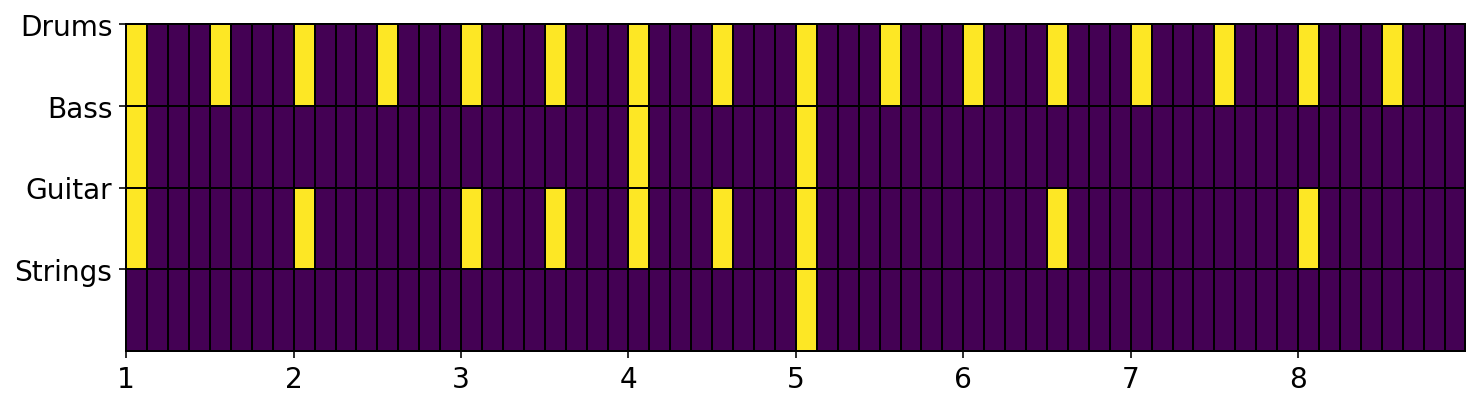

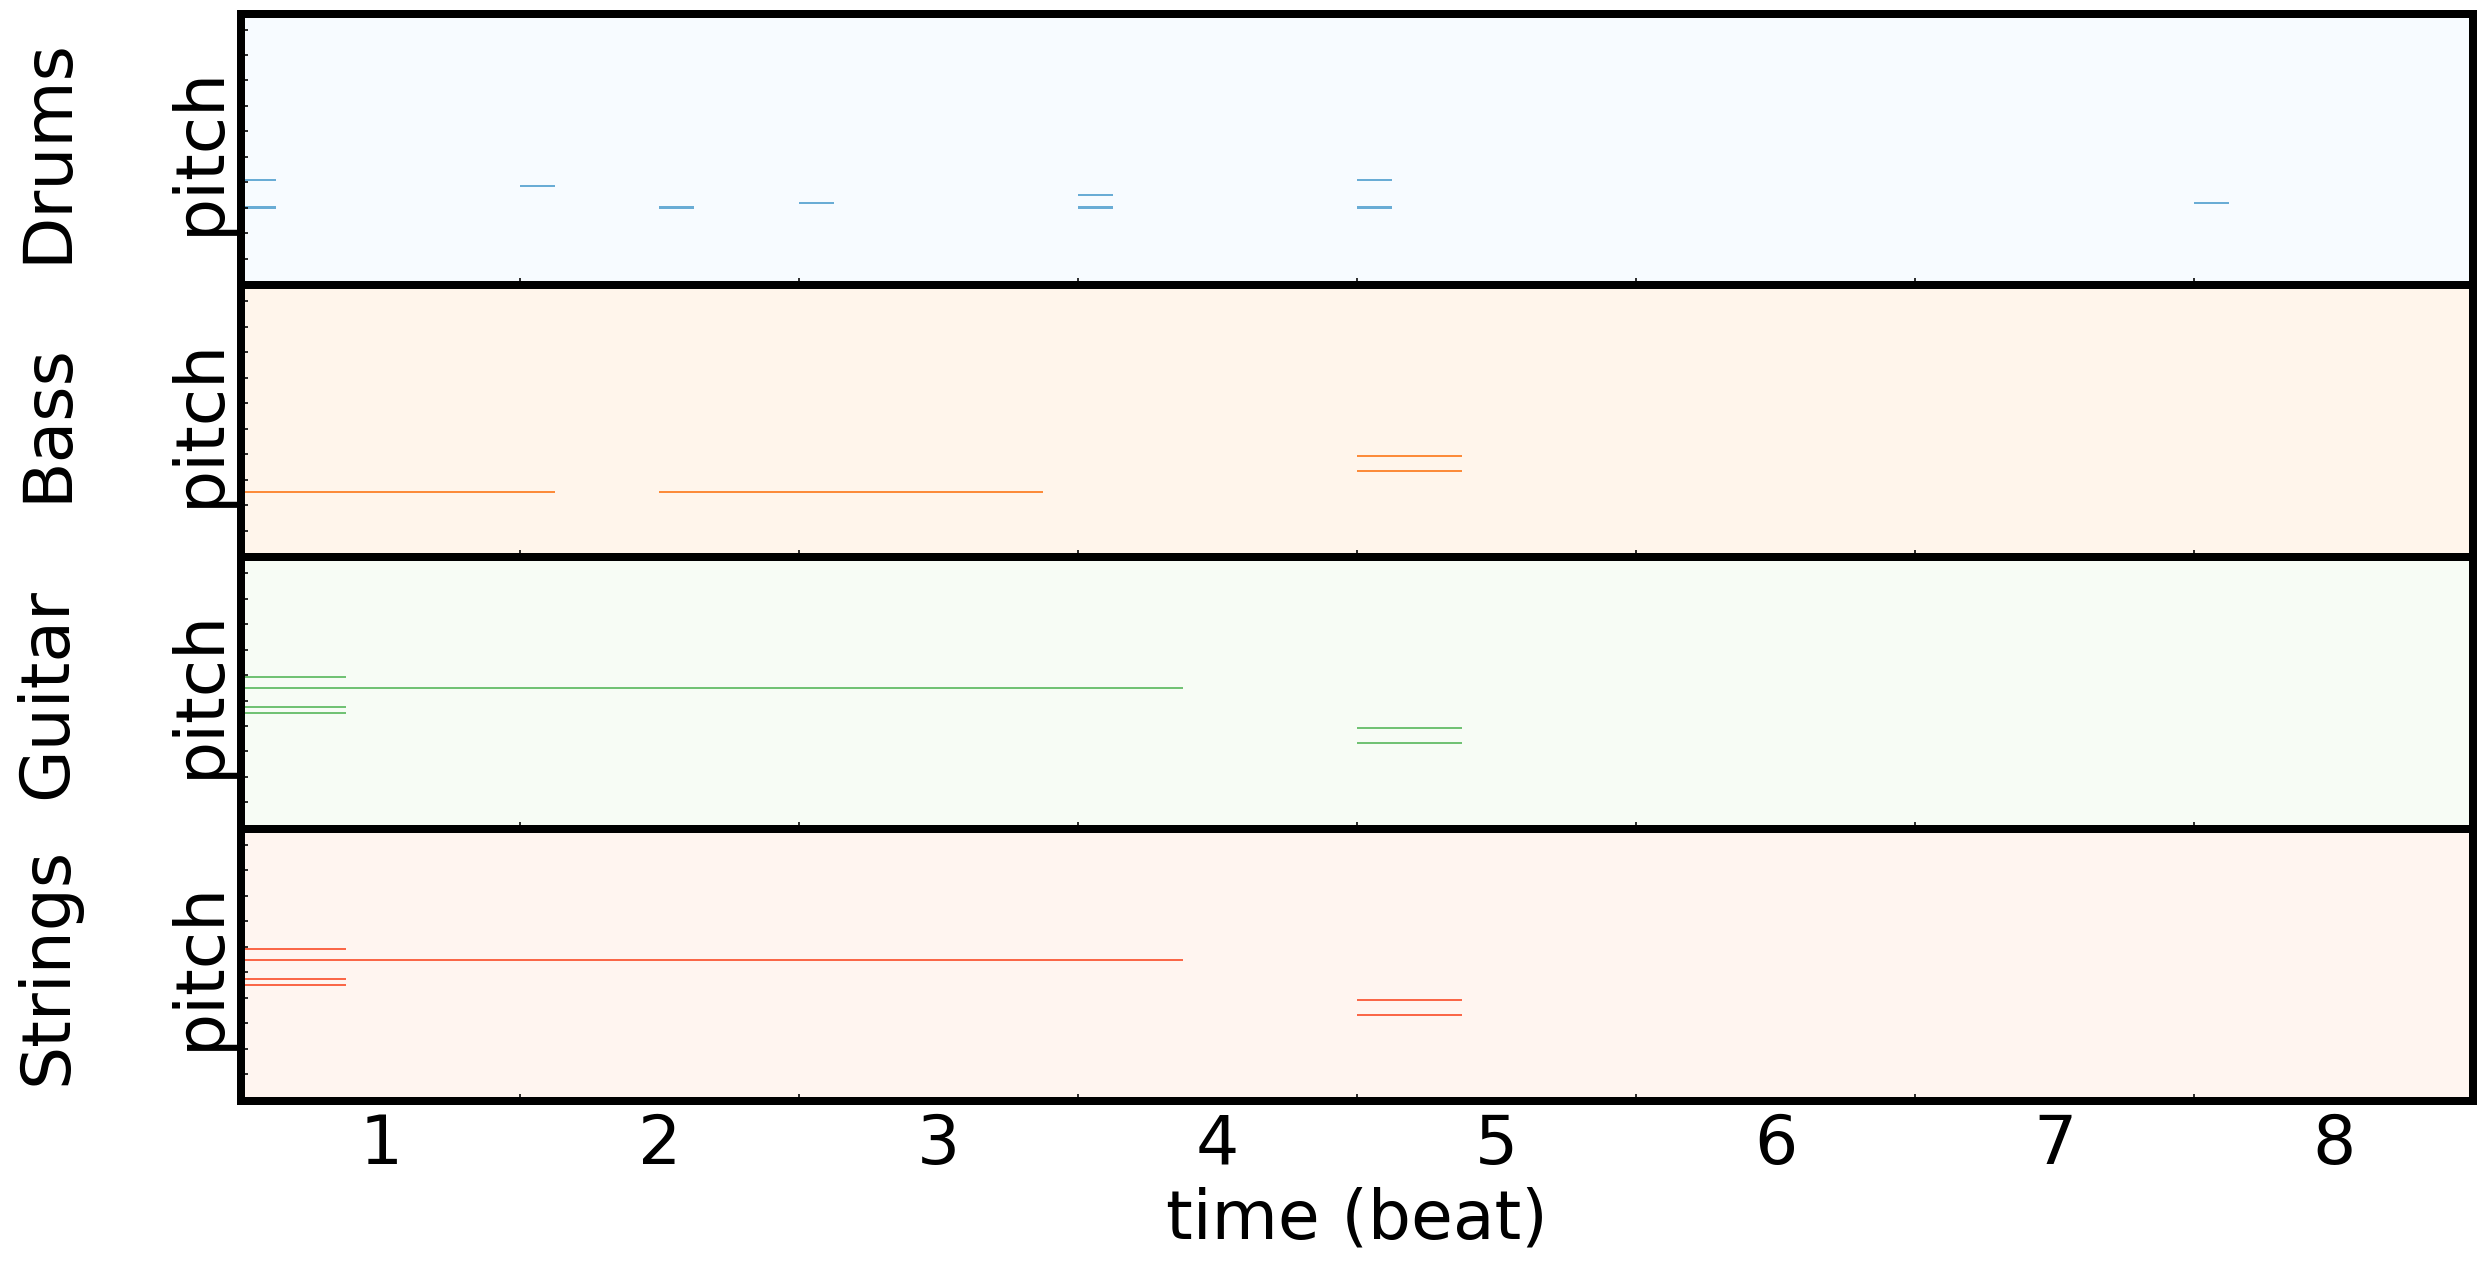

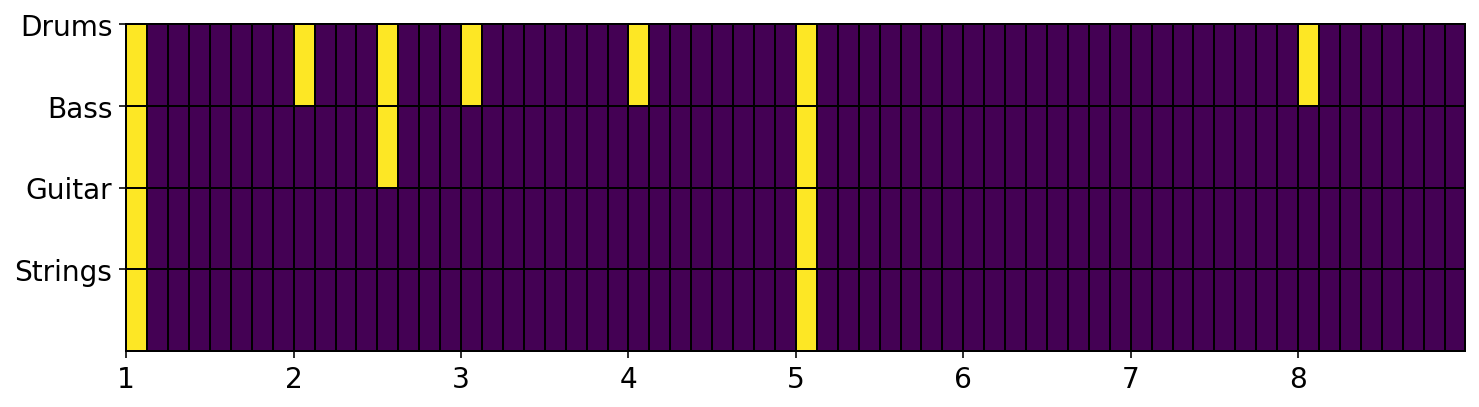

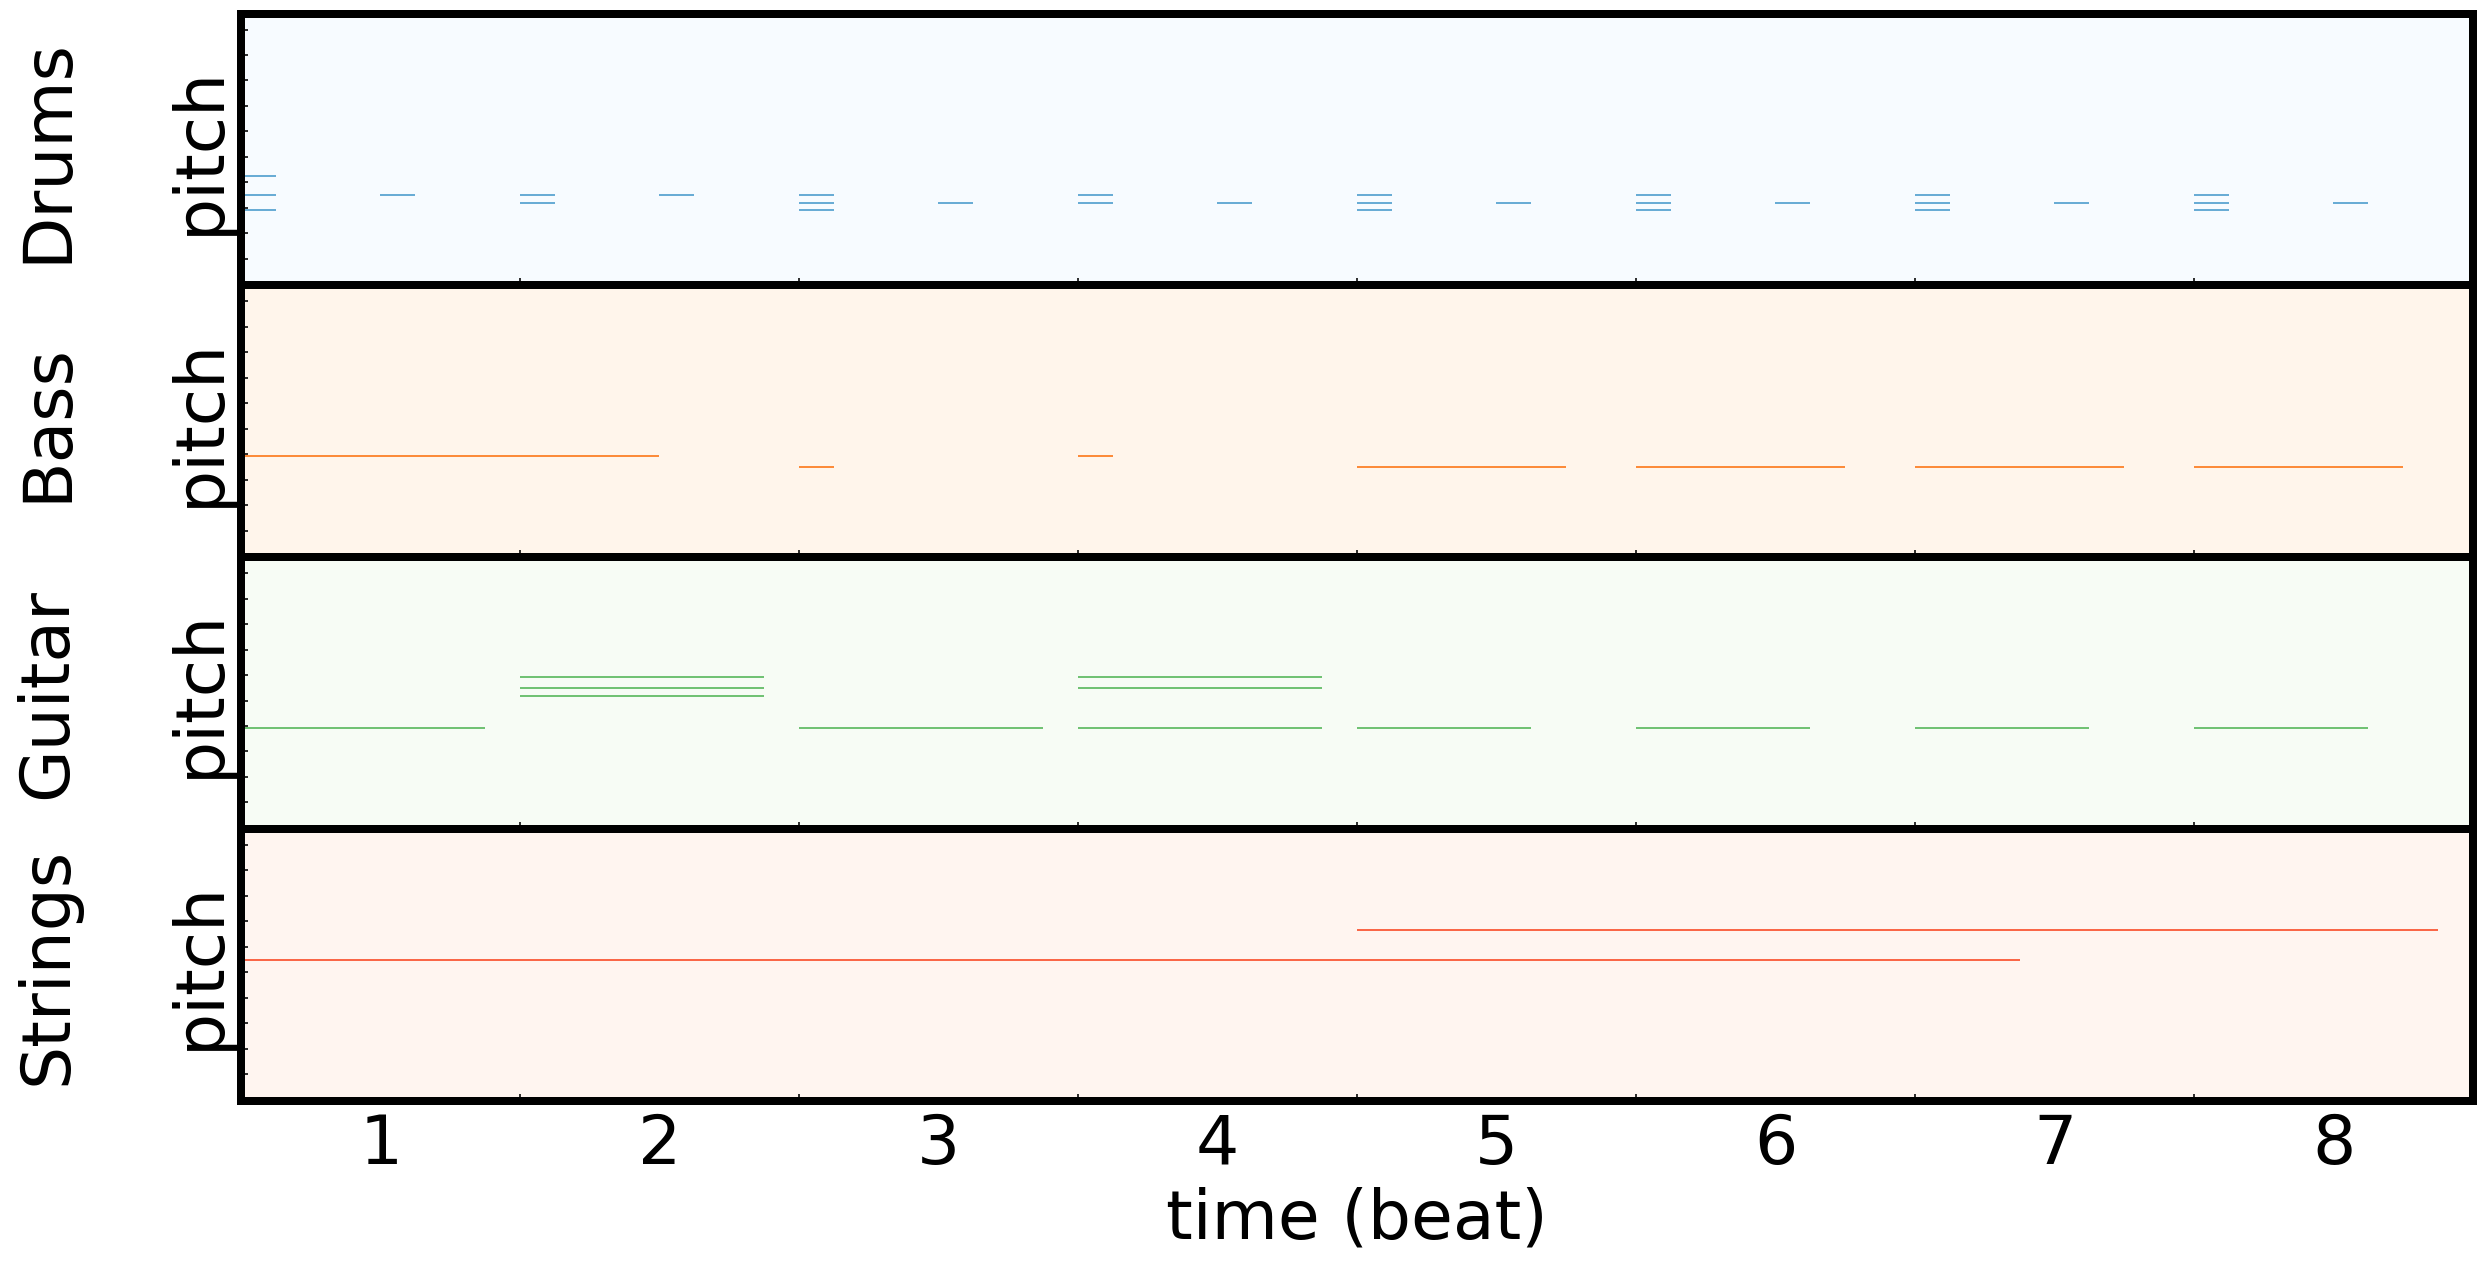

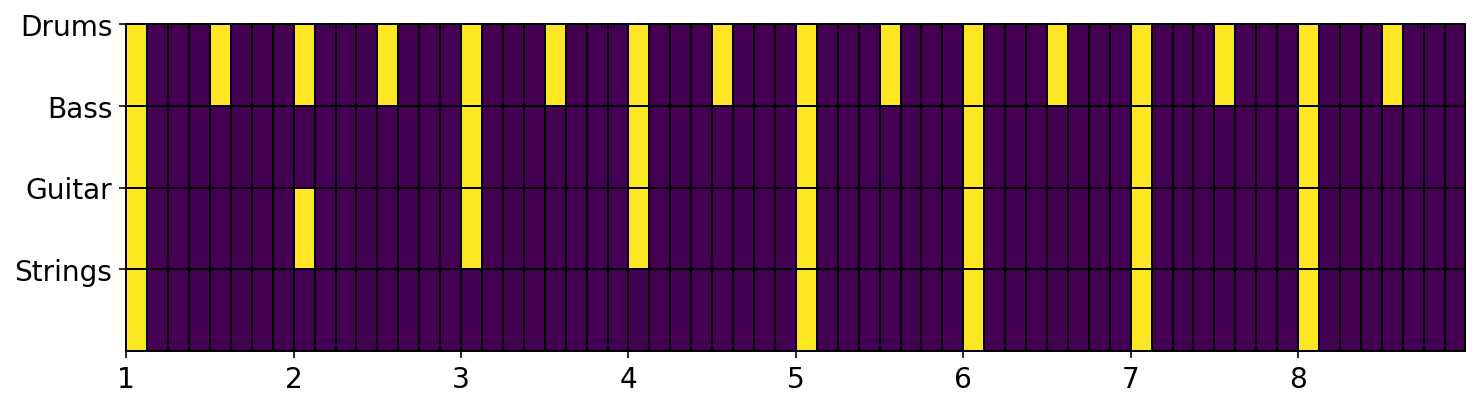

In [11]:
structure = False

n_sequences = 5
d_model = params['model']['d']
n_bars = params['model']['n_bars']
n_tracks = params['model']['n_tracks']
n_timesteps = 4*params['model']['resolution']
dir = 'tmpmusic/'

bs = n_sequences
track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]

s, s_tensor = None, None
if structure:
    # Build test structure tensor
    s_tensor = torch.zeros(n_bars, n_tracks, n_timesteps)
    s_tensor[:, 0, ::8] = 1 # Drums
    s_tensor[:, 1, ::4] = 1 # Bass
    s_tensor[:, 2, ::6] = 1 # Guitar
    s_tensor[:, 3, ::6] = 1 # Piano
    s_tensor = s_tensor.bool()
    s_tensor = s_tensor.unsqueeze(0).repeat(bs, 1, 1, 1)
    s = vae.decoder._structure_from_binary(s_tensor)

z = generate_z(bs, d_model)
mtp, s_tensor = generate_music(vae, z, s, s_tensor)
save(mtp, dir, s_tensor, track_data)